# This notebook performs both real and reciprocal space calibration on 4D-STEM SEND datasets
Expected input data:
- 256 x 256 scans of 500 nm pitch, gold-coated, carbon cross-grating
- Camera lengths of 20 or 40 cm (others may work but may fail)
- Minimum of 2 grid bars (i.e. enclosing a square) visible; high magnifications (> 200 kx) will cause real space calibration to fail

```yaml
plotting:
    value: True
    explanation: 'Set to True to plot diagnostic information'
    prompt: 'Plot diagnostics'
remex_hints:
    value: 'standard_science_cluster'
    explanation: 'Hints to the workflow engine regarding cluster processing. Please consult the beamline staff before changing this. Valid choices are: standard_science_cluster, ptypy_mpi, ptyrex_mpi, local.'
    prompt: 'Remote execution hints'
```

In [1]:
# Assignment of global variables
# dataset name
data_label = '20230515_au_xgrating/20230515_135216'
# notebook name
notebook = 'r_q_calibration_bxflow'
BEAMLINE = 'e02'
YEAR = '2023'
VISIT = 'mg33068-1'
plotting = True

In [2]:
%%capture --no-display
%matplotlib widget
import hyperspy.api as hs
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
from py4DSTEM import DataCube
from py4DSTEM.process.calibration import fit_ellipse_amorphous_ring
from py4DSTEM.process.calibration.origin import get_origin, get_probe_size
from py4DSTEM.visualize import show, add_scalebar, add_ellipses, add_circles
import h5py
from scipy.ndimage import rotate, maximum_filter1d
from scipy.signal import find_peaks
from skimage.transform import SimilarityTransform, AffineTransform, warp
from scipy.interpolate import interp1d
import json

### Global variables
Do not change these if you don't know what they do.

In [3]:
DISPLAY = 'dp_max' # Sets whether the maximum or mean diffraction pattern is used: 'dp_mean' or 'dp_max'
RECIPROCAL_WINDOW = 0.1 # Proportion of cropped diffraction pattern for getting probe positions: 0. to 1.

FIT_RADII_MULTIPLIER = 4.2 # Fitting parameter for ellipticity
FIT_RADII_POWER = 1.2 # Fitting parameter for ellipticity
EL_ORIGIN_THRESHOLD = 3. # Threshold for ellipse origin displacement from mean position in pixels
EL_A_B_THRESHOLD = 0.1 # Threshold ratio of difference of ellipse major axis to minor: 0. to 1.
MATCH_PEAKS = 4 # Number of peaks to be initially used for q scale measurement
Q_PEAK_THRESHOLD = 0.05 # Threshold for difference between measured and expected peak position for measuring q scale

ADF_PAD = 5 # Pixels padding the virtual ADF detector radii relative to the fitting radii
CALIBRATED_DISTANCE = 5e-07 # Pitch of the cross-grating: 5e-07 m
ANGULAR_START = 0. #Degrees
ANGULAR_STOP = 180. #Degrees
ANGULAR_STEP = 0.5
ORTHOGONAL_WINDOW = 10 # Number of angular indices to check orthogonal maximum (related to ANGULAR_STEP)

### Defining functions

In [4]:
def print_metadata(file_paths):
    '''
    Convenience function to print the relevant metadata from 4D-STEM .hdr
    files, selected using glob, for example.
    
    Parameters
    ----------
    file_paths : list of str
        List of the file paths for the .hdr files; can be a single path if
        only one file is of interest
    '''
    with h5py.File(file_paths, 'r') as f:
        print('For the file \'{cal_meta}\':\n\t'
              'Nominal camera length is {cl} cm\n\t'
              'Magnification is {magni} x\n'
              .format(cal_meta=os.path.basename(file_paths),
                      cl=f['metadata/nominal_camera_length(m)'][()]*100,
                      magni=f['metadata/magnification'][()]))

def radial_profile(data, x0, y0):
    '''
    Generates a radial profile (a.k.a. a radial average) around an origin
    (x0,y0) in a 2D array/image.
    
    Parameters
    ----------
    data : array_like
        2D array containing the data to be radially averaged.
    x0 : float or int
        x co-ordinate of origin
    y0 : float or int
        y co-ordinate of origin
    
    Returns
    -------
    tuple of 1D arrays
        A tuple with its zeroth element being the 1D array radial distances in
        array indices/pixels, and with the first element being the 1D array of
        the mean intensity at a given radial distance.
    '''
    x, y = np.indices((data.shape))
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin/nr
    return np.unique(r), radialprofile

def find_origin_using_cropped_signal(data, rad, x0, y0, crop_window_size):
    '''
    Finds the probe origins on a cropped instance of the input data.
    
    Parameters
    ----------
    data : DataCube
        4D-STEM dataset for which the origins will be found
    rad : float
        Approximate radius of the central beam in pixels
    x0 : float
        Approximate x coordinate of the central beam in pixels
    y0 : float
        Approximate y coordinate of the central beam in pixels
    crop_window_size : float (0.0 to 1.0)
        Proportion of the diffraction plane to use as a search window around
        the approximate centre
    
    Returns
    -------
    origins : array
        A numpy array of shape (2, Rx,Ry) containing the central coordinates at
        each real space location
    '''
    window = int(np.ceil(rad + data.data.shape[2]*crop_window_size))
    x0r, y0r = int(x0//1), int(y0//1)
    x_lower, x_upper =  x0r - window, x0r + window
    y_lower, y_upper =  y0r - window, y0r + window
    d_cent = DataCube(data.data[:,:,x_lower:x_upper,y_lower:y_upper])
    origins = get_origin(d_cent, r=rad, rscale=1.1)
    origins = np.array((origins[0], origins[1]))
    origins[0] += x_lower
    origins[1] += y_lower
    return origins

def apply_affine_from_ellipse(data, x0, y0, a, b, theta):
    '''
    Determines the affine transform matrix to circularise a given ellipse and
    applies the transformation to an input image.
    
    Parameters
    ----------
    data : 2D array
        The diffraction pattern to which the affine transformation (derived
        from the input ellipsis parameters) will be applied
    x0 : float or int
        x co-ordinate of the origin in pixels
    y0 : float or int
        y co-ordinate of the origin in pixels
    a : float
        Ellipsis major axis in pixels
    b : float
        Ellipsis minor axis in pixels
    theta : float
        Elliptical rotation in radians
    
    Returns
    -------
    warped : 2D array
        The affine transformed diffraction pattern
    affine : 2D array
        The affine transformation matrix
    '''
    # Rotation array transposed from normal because of the convention of x- and
    # y-axis assignment used in this script: x is array.shape[0], y is
    # array.shape[1], opposite to the convention used for image axes -- this is
    # for consistency with py4DSTEM's function docstrings
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
    
    # Scaling is relative to the mean/median of the ellipse axes
    scaling = np.array([[a/((a + b)/2), 0],
                        [0, b/((a + b)/2)]])
    
    shift_x = int(x0)
    shift_y = int(y0)
    
    distortion = np.dot(rotation.T,np.dot(scaling, rotation))
    
    affine = np.array([[distortion[0, 0], distortion[0, 1], 0.00],
                       [distortion[1, 0], distortion[1, 1], 0.00],
                       [0.00, 0.00, 1.00]])
    
    # Having to flip axes for SimilarityTransform; y preceeds x
    tf_shift = SimilarityTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = SimilarityTransform(translation=[shift_y, shift_x])
    
    tf_distortion = AffineTransform(matrix=affine)
    tf_correction = (tf_shift + (tf_distortion + tf_shift_inv)).inverse
    warped = warp(data, tf_correction, order=1, preserve_range=True)
    return warped, affine

def apply_affine_from_square(data, x0, y0, a, b, theta, phi):
    '''
    Determines the affine transform matrix to fit a square and applies the
    transformation to an input image.
    
    Parameters
    ----------
    data : 2D array
        The diffraction pattern to which the affine transformation (derived
        from the input ellipsis parameters) will be applied
    x0 : float or int
        x co-ordinate of the origin in pixels
    y0 : float or int
        y co-ordinate of the origin in pixels
    a : float
        Square a axis length in pixels
    b : float
        Square b axis length in pixels
    theta : float
        a axis orientation to image x axis in radians
    phi : float
        Angle subtended by a and b (should be close to pi/2)
    
    Returns
    -------
    warped : 2D array
        The affine transformed image
    affine : 2D array
        The affine transformation matrix
    '''
    # Rotation array transposed from normal because of the convention of x- and
    # y-axis assignment used in this script: x is array.shape[0], y is
    # array.shape[1], opposite to the convention used for image axes -- this is
    # for consistency with py4DSTEM's function docstrings
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
    shearing = np.array([[1, np.cos(phi)],
                         [0,1]])
    # Scaling is relative to the mean/median of the a and b axes
    scaling = np.array([[a/((a + b)/2), 0],
                        [0, b/((a + b)/2)]])
    
    shift_x = int(x0)
    shift_y = int(y0)
    
    distortion = np.dot(rotation.T,np.dot(scaling, np.dot(shearing, rotation)))
    
    affine = np.array([[distortion[0, 0], distortion[0, 1], 0.00],
                       [distortion[1, 0], distortion[1, 1], 0.00],
                       [0.00, 0.00, 1.00]])
    
    # Having to flip axes for SimilarityTransform; y preceeds x
    tf_shift = SimilarityTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = SimilarityTransform(translation=[shift_y, shift_x])
    
    tf_distortion = AffineTransform(matrix=affine)
    tf_correction = (tf_shift + (tf_distortion + tf_shift_inv)).inverse
    warped = warp(data, tf_correction, order=1, preserve_range=True)
    return warped, affine

def apply_affine_from_matrix(data, x0, y0, affine_matrix):
    shift_x = int(x0)
    shift_y = int(y0)
    tf_shift = SimilarityTransform(translation=[-shift_y, -shift_x])
    tf_shift_inv = SimilarityTransform(translation=[shift_y, shift_x])
    tf_distortion = AffineTransform(matrix=affine_matrix)
    transformation = (tf_shift + (tf_distortion + tf_shift_inv)).inverse
    warped = warp(data, transformation, order=1, preserve_range=True)
    return warped

def ticks_off(axis):
    '''
    Convenience function to turn off axis ticks in a Matplotlib plot.
    
    Parameters
    ----------
    axis : matplotlib.pyplot.Axes
        Axes object to which the ticks will be removed
    '''
    axis.set_xticks([])
    axis.set_yticks([])

def create_profile_from_angle(image, angle):
    rot_image = rotate(image, angle, reshape=False)
    rot_mask = np.ma.masked_where(rot_image == 0, rot_image)
    mean_profile = np.ma.mean(rot_mask, axis=0)
    return mean_profile

def find_peaks_and_calibration(profile, fov, theta):
    ax_len = abs(profile.shape[0]*(CALIBRATED_DISTANCE/fov)
                 *np.cos(np.radians(theta)))
    window_guess = int(ax_len*0.9)
    filtered_profile = maximum_filter1d(profile, size=window_guess)
    peaks = find_peaks(filtered_profile, width=window_guess)[0]
    
    if len(peaks) < 2:
        print('Insufficient peaks found: peak finding failed.')
        return None, None
    else:
        peak_spacing = np.diff(peaks)
        for i in range(1, len(peak_spacing)):
            if (peak_spacing[i] > 1.8*peak_spacing[i - 1]
                    and peak_spacing[i] > 1.8*peak_spacing[i + 1]):
                print('Discontinuity in peak spacing: inserting missing peak.')
                insert_val = (peaks[i] + peaks[i + 1])/2
                peaks = np.insert(peaks, i + 1, insert_val)
                peak_spacing = np.diff(peaks)
                
        mean_peak_spacing = peak_spacing.mean()
        std_peak_spacing = peak_spacing.std()
        rel_std = std_peak_spacing/mean_peak_spacing
        if rel_std > 0.1:
            print('Relative peak spacing standard deviation is {std:.1f}'
                  ' percent; peak finding may have failed.'
                  .format(std=rel_std*100))
        return mean_peak_spacing, peaks

def build_xy_coords_from_rotated_peaks(x_peaks, x_extent, y_extent):
    xys = np.empty((2,2, x_peaks.shape[0]))
    for k, x in enumerate(x_peaks):
        xys[0,:,k] = x,0
        xys[1,:,k] = x,y_extent
    return xys
    
def point_rotate(x, y, x0, y0, theta_d):
    theta = np.radians(theta_d)
    x_rot = (x - x0)*np.cos(theta) - (y - y0)*np.sin(theta) + x0
    y_rot = (x - x0)*np.sin(theta) + (y - y0)*np.cos(theta) + y0
    return x_rot, y_rot

## Paths and Preprocessing

In [5]:
cal_timestamp = data_label.split('/')[-1]
base_path = f'/dls/{BEAMLINE}/data/{YEAR}/{VISIT}/processing/Merlin'
meta_path = f'{base_path}/{data_label}/{cal_timestamp}.hdf'
data_path = f'{base_path}/{data_label}/{cal_timestamp}_data.hdf5'
save_dir = f'{base_path}/{data_label}'

In [6]:
print_metadata(meta_path)

For the file '20230515_135216.hdf':
	Nominal camera length is 20.0 cm
	Magnification is 50000 x



In [7]:
cal_d = hs.load(data_path, lazy=True)
cal_d.axes_manager[0].offset = 0
cal_d.axes_manager[1].offset = 0

with h5py.File(meta_path, 'r') as f:
    cal_mag = f['metadata/magnification'][()]
    cal_fov = f['metadata/field_of_view(m)'][()]
    cal_cam_len = f['metadata/nominal_camera_length(m)'][()]
    cal_ht = f['metadata/ht_value(V)'][()]

In [8]:
with h5py.File('/dls_sw/e02/medipix_mask/Merlin_12bit_mask.h5', 'r') as f:
    mask = f['data/mask'][()]

mask = mask.astype('bool')
cal_d_mask = cal_d*np.invert(mask)
cal_d_mask.compute()

[########################################] | 100% Completed | 126.87 s


In [9]:
cal_data = DataCube(cal_d_mask.data)

## Reciprocal Space Calibration

In [10]:
cal_data.get_dp_mean()

approx_probe_semiangle, approx_qx0, approx_qy0 = get_probe_size(
    cal_data.tree('dp_mean').data)

reciprocal_origins = find_origin_using_cropped_signal(cal_data,
                                                      approx_probe_semiangle,
                                                      approx_qx0,
                                                      approx_qy0,
                                                      RECIPROCAL_WINDOW)

cal_data.calibration.set_origin(reciprocal_origins)

cal_data.get_dp_max(shift_center=True)
cal_data.get_dp_mean(shift_center=True)

mean_probe_semiangle, mean_qx0, mean_qy0 = get_probe_size(
    cal_data.tree('dp_mean').data)

Finding origins: 100%|██████████| 65.0k/65.0k [01:07<00:00, 964DP/s]  


In [11]:
approx_q_dp, approx_i_dp = radial_profile(
    cal_data.tree(DISPLAY).data, mean_qx0, mean_qy0)

dp_peaks, dp_props = find_peaks(approx_i_dp, (None,None))
first_peak = dp_peaks[np.argsort(dp_props['peak_heights'])][::-1][0]
au_k_first_4 = np.array([0.4247, 0.4904, 0.6935, 0.8132])

au_peak_ratios = au_k_first_4/au_k_first_4[0]
dp_ord_peaks = (au_peak_ratios*first_peak).astype('int')

In [12]:
r_inners = (dp_ord_peaks - (mean_probe_semiangle
               *((FIT_RADII_MULTIPLIER*dp_ord_peaks**FIT_RADII_POWER)
                 /cal_data.tree(DISPLAY).data.shape[0])))
r_outers = (dp_ord_peaks + (mean_probe_semiangle
               *((FIT_RADII_MULTIPLIER*dp_ord_peaks**FIT_RADII_POWER)
                 /cal_data.tree(DISPLAY).data.shape[0])))

fit_radii = [(r_inners[i], r_outers[i]) for i in range(len(r_inners))]

el_centres = []
el_as = []
el_bs = []
el_thetas = []
el_bad_fits = []
mean_centre = (mean_qx0, mean_qy0)

for i in range(len(fit_radii)):
    el_x0, el_y0, el_a,el_b,el_theta = fit_ellipse_amorphous_ring(
        data=cal_data.tree(DISPLAY).data,
        center=mean_centre,
        fitradii=fit_radii[i])[0]
    
    el_centres.append((el_x0, el_y0))
    el_as.append(el_a)
    el_bs.append(el_b)
    el_thetas.append(el_theta)
    if (np.abs(el_x0 - mean_qx0) > EL_ORIGIN_THRESHOLD
            or np.abs(el_y0 - mean_qy0) > EL_ORIGIN_THRESHOLD):
        el_bad_fits.append(True)
    elif (np.abs(el_a - el_b)/el_a) > EL_A_B_THRESHOLD:
        el_bad_fits.append(True)
    else:
        el_bad_fits.append(False)

el_dict = dict(center=el_centres.copy(),
               a=el_as.copy(),
               b=el_bs.copy(),
               theta=el_thetas.copy(),
               color='black',
               linewidth=3,
               alpha=0.75,
               linestyle=['solid' if not el_bad_fits[i]
                          else 'dashed' for i in range(len(el_centres))])

fit_dict = dict(center=[mean_centre for i in range(len(fit_radii))],
                radii=fit_radii)

if True in el_bad_fits:
    del el_centres[el_bad_fits.index(True)]
    del el_as[el_bad_fits.index(True)]
    del el_bs[el_bad_fits.index(True)]
    del el_thetas[el_bad_fits.index(True)]

mean_el_centre = tuple(np.mean(el_centres, axis=0))
mean_el_a = np.mean(el_as)
mean_el_b = np.mean(el_bs)
mean_el_theta = np.mean(el_thetas)

mean_el_dict = dict(
    center=mean_el_centre,
    a=mean_el_a,
    b=mean_el_b,
    theta=mean_el_theta)

mean_warped, mean_affine = apply_affine_from_ellipse(
    cal_data.tree(DISPLAY).data.copy(),
    mean_el_centre[0],
    mean_el_centre[1],
    mean_el_a,
    mean_el_b,
    mean_el_theta)

mean_resid = mean_warped - cal_data.tree(DISPLAY).data.copy()
mean_resid_lim = np.abs(mean_resid).max()

/dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 2400.
  warnings.warn(errors[info][0], RuntimeWarning)


In [13]:
refined_q_dp, refined_i_dp = radial_profile(mean_warped,
                                            mean_el_centre[0],
                                            mean_el_centre[1])

refined_dp_peaks, refined_dp_props = find_peaks(refined_i_dp, (None,None))
refined_dp_ord_peaks = refined_dp_peaks[np.argsort(
    refined_dp_props['peak_heights'])][::-1][:MATCH_PEAKS]
refined_dp_ord_peaks.sort()


good_peaks = []
au_bad_peaks = []
au_good_peaks = []
refined_peak_ratios = refined_dp_ord_peaks/refined_dp_ord_peaks[0]
for i in range(len(au_peak_ratios)):
    peak_ind = np.abs(refined_peak_ratios - au_peak_ratios[i]).argmin()
    peak_diff = np.abs(refined_peak_ratios - au_peak_ratios[i]).min()
    if peak_diff < Q_PEAK_THRESHOLD:
        good_peak = refined_dp_ord_peaks[peak_ind]
        au_good_peak = au_k_first_4[i]
        good_peaks.append(good_peak)
        au_good_peaks.append(au_good_peak)
    else:
        au_bad_peak = au_k_first_4[i]
        au_bad_peaks.append(au_bad_peak)
        continue


refined_dict = dict(center=[(mean_el_centre[0], mean_el_centre[1])
                            for i in range(len(good_peaks))],
                    R=good_peaks,
                    color='black',
                    alpha=0.75,
                    linewidth=3,
                    linestyle='solid')

q_scales = np.array(au_good_peaks)/np.array(good_peaks)
q_scale = q_scales.mean()
q_std = q_scales.std()

if q_std > 0.01*q_scale:
    print('Warning: relative standard deviation of q pixel scale is greater '
          'than 1%; peak fitting may have failed')

bad_dict = dict(center=[(refined_qx0, refined_qy0)
                        for i in range(len(au_bad_peaks))],
                R=[int(au_bad_peaks[i]/q_scale)
                   for i in range(len(au_bad_peaks))],
                color='black',
                alpha=0.75,
                linewidth=3,
                linestyle='dashed')

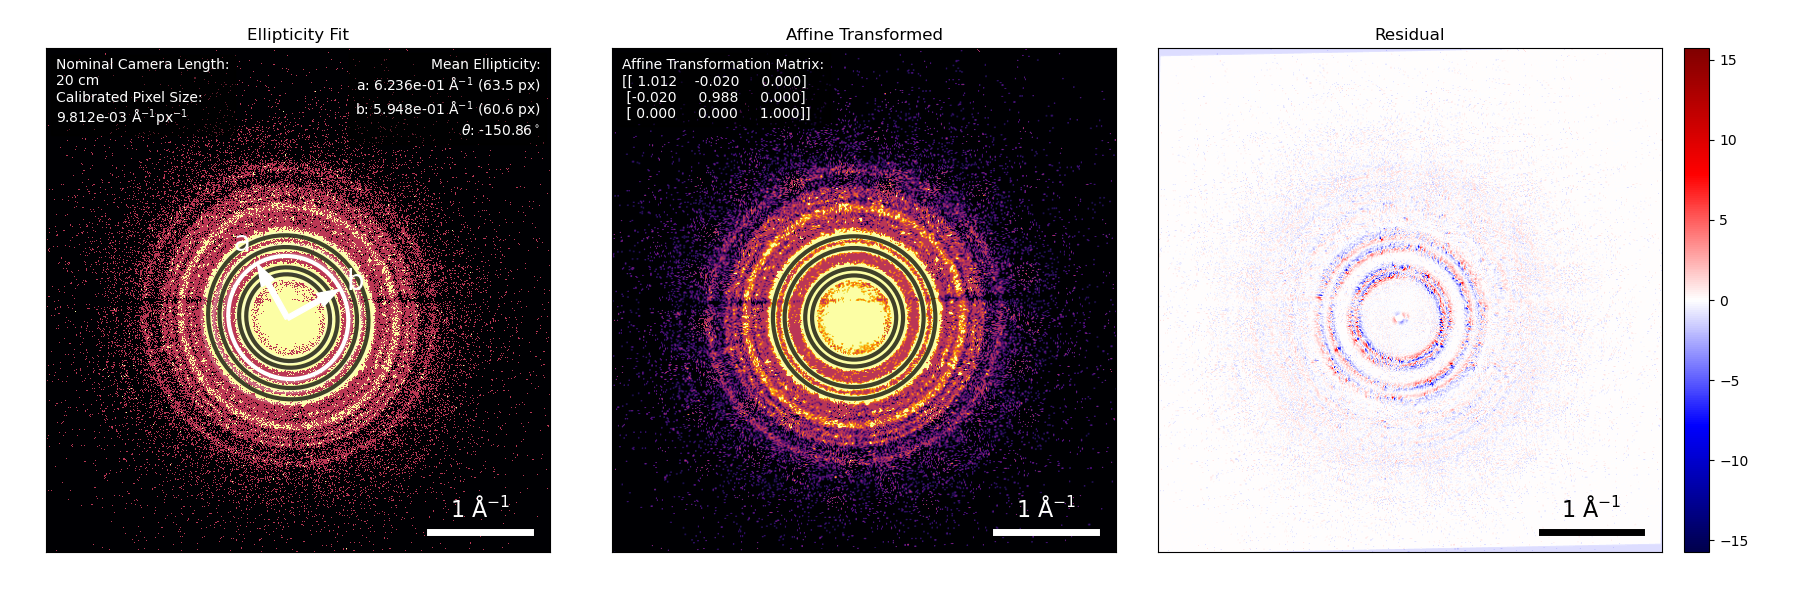

In [14]:
if plotting:
    fig, ax = plt.subplots(ncols=3, figsize=(18,6))

    im_lim_u = np.percentile(cal_data.tree(DISPLAY).data, 95)
    im_lim_l = np.percentile(cal_data.tree(DISPLAY).data, 5)

    for i in range(len(el_dict.keys())):
        fit_dict['color'] = 'white'
        fit_dict['alpha'] = 0.2
        fit_dict['linestyle'] = None

    show(cal_data.tree(DISPLAY).data,
               ellipse=el_dict,
               annulus=fit_dict,
               figax=(fig,ax[0]),
               ticks=False,
               scalebar=False,
               title='Ellipticity Fit',
               cmap='inferno',
               vmin=0.05,
               vmax=0.95)
    
    q_lengths = {0.06:5,
                 0.09:2,
                 0.1:2,
                 0.12:2,
                 0.15:1,
                 0.2:1,
                 0.4:0.5,
                 1.0:0.25}
    
    q_bar = {'Nx':cal_data.tree(DISPLAY).data.shape[0],
             'Ny':cal_data.tree(DISPLAY).data.shape[1],
             'length':q_lengths[cal_cam_len],
             'width':5,
             'position':'br',
             'color':'white',
             'label':True,
             'pixelsize':q_scale,
             'pixelunits':'Å$^{-1}$'}
    
    add_scalebar(ax[0], q_bar)

    mean_el_dict['color'] = 'w'
    mean_el_dict['linewidth'] = 3

    add_ellipses(ax[0], mean_el_dict)

    ax[0].text(x=10,
               y=10,
               s='Nominal Camera Length:\n{cl:.0f} cm\n'
                 'Calibrated Pixel Size:\n{q:.3e} Å$^{{-1}}$px$^{{-1}}$'
                 .format(cl=cal_cam_len*1e2, q=q_scale),
               ha='left',
               va='top',
               color='white',
               bbox=dict(facecolor='black', alpha=0.5))

    ax[0].text(x=505,
               y=10,
               s='Mean Ellipticity:\n'
                 'a: {a:.3e} Å$^{{-1}}$ ({a2:.1f} px)\n'
                 'b: {b:.3e} Å$^{{-1}}$ ({b2:.1f} px)\n'
                 r'$\theta$: {th:.2f}$^\circ$'
                 .format(a=mean_el_a*q_scale,
                         a2=mean_el_a,
                         b=mean_el_b*q_scale,
                         b2=mean_el_b,
                         th=np.degrees(mean_el_theta)),
               ha='right',
               va='top',
               color='white',
               bbox=dict(facecolor='black', alpha=0.5))

    a_dy = mean_el_a*np.sin(mean_el_theta)
    a_dx = mean_el_a*np.cos(mean_el_theta)
    b_dy = mean_el_b*np.sin(mean_el_theta - (np.pi/2))
    b_dx = mean_el_b*np.cos(mean_el_theta - (np.pi/2))

    a_end = (mean_qy0 + a_dy - 7, mean_qx0 + a_dx - 7)
    b_end = (mean_qy0 + b_dy + 7, mean_qx0 + b_dx + 7)
    
    ax[0].annotate('a',
                   xy=a_end,
                   color='white',
                   fontsize=20,
                   ha='right',
                   va='bottom')
    
    ax[0].annotate('b',
                   xy=b_end,
                   color='white',
                   fontsize=20,
                   ha='left',
                   va='bottom')
    
    ax[0].arrow(mean_qy0,
                mean_qx0,
                a_dy,
                a_dx,
                length_includes_head=True,
                width=5, 
                color='white',
                capstyle='round')
    
    ax[0].arrow(mean_qy0,
                mean_qx0,
                b_dy,
                b_dx,
                length_includes_head=True,
                width=5,
                color='white',
                capstyle='round')

    ax[1].imshow(mean_warped, vmin=im_lim_l, vmax=im_lim_u, cmap='inferno')

    ticks_off(ax[1])
    ax[1].set_title('Affine Transformed')
    
    add_circles(ax[1], refined_dict)
    add_circles(ax[1], bad_dict)
                                   
    add_scalebar(ax[1], q_bar)

    aff_str = np.array2string(mean_affine,
                              precision=3,
                              separator='    ',
                              floatmode='fixed')

    ax[1].text(x=10,
               y=10,
               s='Affine Transformation Matrix:\n' + aff_str,
               ha='left',
               va='top',
               color='white',
               bbox=dict(facecolor='black', alpha=0.5))

    pos = ax[2].imshow(mean_resid,
                       vmin=-mean_resid_lim,
                       vmax=mean_resid_lim,
                       cmap='seismic')

    ax[2].set_title('Residual')
    ticks_off(ax[2])
    plt.colorbar(pos, ax=ax[2], fraction=0.046, pad=0.04)

    q_bar['color'] = 'black'
    
    add_scalebar(ax[2], q_bar)

    plt.subplots_adjust(left=0.01, 
                        right=0.95,
                        top=0.92,
                        bottom=0.08,
                        wspace=0.01)
    
    plt.savefig(f'{save_dir}{os.sep}{cal_timestamp}_q_cal.png', dpi=300)

## Real Space Calibration

In [15]:
adf_det = ((0,0), (fit_radii[0][0] - ADF_PAD, fit_radii[-1][1] + ADF_PAD))
cal_data.get_virtual_image(mode='annulus',
                           geometry=adf_det,
                           name='vADF',
                           centered=True,
                           shift_center=True);

thetas = np.arange(ANGULAR_START, ANGULAR_STOP, ANGULAR_STEP)

adf = cal_data.tree('vADF').data.copy()
maxes = np.empty((len(thetas), 2))    

for i in range(len(thetas)):
    mean_max = create_profile_from_angle(adf, thetas[i]).max()
    mean_max_arr = np.array([thetas[i], mean_max])
    maxes[i] = mean_max_arr

maxi_1 = maxes[maxes[:,1].argmax()]
ind_90 = np.abs(maxes[:,0] - ((maxi_1[0] + 90) % ANGULAR_STOP)).argmin()
maxi_90 = maxes[ind_90 - ORTHOGONAL_WINDOW:ind_90 + ORTHOGONAL_WINDOW]
maxi_2 = maxi_90[maxi_90[:,1].argmax()]
profile_1 = create_profile_from_angle(adf, maxi_1[0])
profile_2 = create_profile_from_angle(adf, maxi_2[0])

space_1, peaks_1 = find_peaks_and_calibration(profile_1, cal_fov, maxi_1[0])
space_2, peaks_2 = find_peaks_and_calibration(profile_2, cal_fov, maxi_2[0])

if space_1 is None or space_2 is None:
    r_success = False
    
else:
    r_success = True
    mean_cal = CALIBRATED_DISTANCE/np.mean([space_1, space_2])

    origin = (int(adf.shape[0]/2), int(adf.shape[1]/2))
    starts1, stops1 = build_xy_coords_from_rotated_peaks(peaks_1,
                                                         adf.shape[0],
                                                         adf.shape[1])
    starts2, stops2 = build_xy_coords_from_rotated_peaks(peaks_2,
                                                         adf.shape[0],
                                                         adf.shape[1])

    x2, y2 = point_rotate(x=starts1[0], y=starts1[1], x0=origin[0],
                          y0=origin[1], theta_d=maxi_1[0])
    x3, y3 = point_rotate(x=stops1[0], y=stops1[1], x0=origin[0],
                          y0=origin[1], theta_d=maxi_1[0])

    x4 = [(x2[i], x3[i]) for i in range(len(x2))]
    y4 = [(y2[i], y3[i]) for i in range(len(y2))]

    x5, y5 = point_rotate(x=starts2[0], y=starts2[1], x0=origin[0],
                          y0=origin[1], theta_d=maxi_2[0])
    x6, y6 = point_rotate(x=stops2[0], y=stops2[1], x0=origin[0],
                          y0=origin[1], theta_d=maxi_2[0])
    x7 = [(x5[i], x6[i]) for i in range(len(x5))]
    y7 = [(y5[i], y6[i]) for i in range(len(y5))]

    f1 = [interp1d(x4[i], y4[i], fill_value='extrapolate')
          for i in range(len(x4))]
    f2 = [interp1d(x7[i], y7[i], fill_value='extrapolate')
          for i in range(len(x7))]

    sq_a = np.diff(peaks_1).mean()
    sq_b = np.diff(peaks_2).mean()
    if maxi_1[0] < maxi_2[0]:
        sq_theta = np.radians(maxi_2[0])
    else:
        sq_theta = np.radians(maxi_1[0])
    sq_phi = np.radians(maxi_2[0] - maxi_1[0])

    adf_warp, adf_affine = apply_affine_from_square(adf,
                                                     int(adf.shape[0]/2),
                                                     int(adf.shape[1]/2),
                                                     sq_a,
                                                     sq_b,
                                                     sq_theta,
                                                     sq_phi)
    adf_resid = adf_warp - adf
    adf_resid_lim = adf_resid.max()

100%|██████████| 65025/65025 [00:13<00:00, 4655.42it/s]


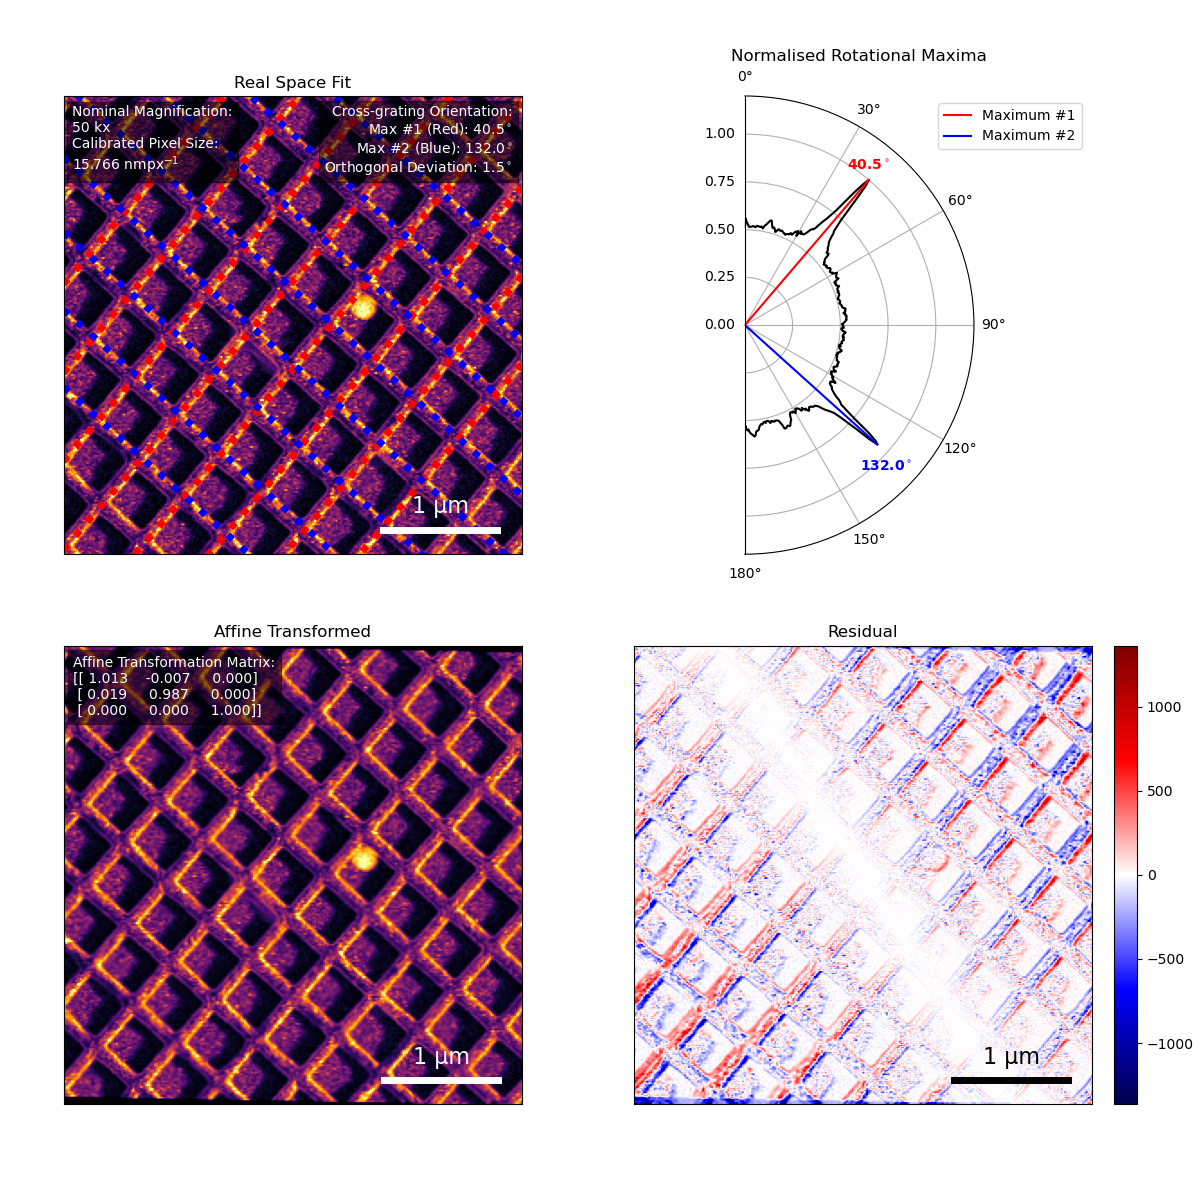

In [16]:
if plotting and r_success:
    fig = plt.figure(figsize=(12,12))
    
    ax_1 = plt.subplot(221)
    ax_2 = plt.subplot(222, polar=True)
    ax_3 = plt.subplot(223)
    ax_4 = plt.subplot(224)

    [ax_1.plot([0,adf.shape[0]],[f1[i](0), f1[i](adf.shape[0])],
              color='red', linewidth=5, linestyle=':')
     for i in range(len(f1))]
    [ax_1.plot([0,adf.shape[1]],[f2[i](0), f2[i](adf.shape[1])],
              color='blue', linewidth=5, linestyle=':')
     for i in range(len(f2))]

    ax_1.imshow(adf, cmap='inferno',
                extent=[0,adf.shape[0],0,adf.shape[1]],
                origin='lower',
                vmin=np.percentile(adf, 1),
                vmax=np.percentile(adf, 99))

    ax_1.text(x=5,
              y=5,
              s='Nominal Magnification:\n{magni:.0f} kx\n'
              'Calibrated Pixel Size:\n{r:.3f} nmpx$^{{-1}}$'
                .format(magni=cal_mag/1e3, r=mean_cal*1e9),
              ha='left',
              va='top',
              color='white',
              bbox=dict(facecolor='black', alpha=0.5))

    ax_1.set_xlim((0, adf.shape[0]))
    ax_1.set_ylim((0, adf.shape[1]))
    ax_1.invert_yaxis()
    ax_1.set_aspect('equal')
    ax_1.set_title('Real Space Fit')

    ticks_off(ax_1)

    r_lengths = {20000:[1, 1e6, 'μm'],
                 25000:[1, 1e6, 'μm'],
                 40000:[1, 1e6, 'μm'],
                 50000:[1, 1e6, 'μm'],
                 60000:[1, 1e6, 'μm'],
                 80000:[500, 1e9, 'nm'],
                 100000:[500, 1e9, 'nm'],
                 120000:[250, 1e9, 'nm'],
                 150000:[250, 1e9, 'nm'],
                 200000:[250, 1e9, 'nm'],
                 250000:[250, 1e9, 'nm']}
    
    r_bar = {'Nx':adf.shape[0],
             'Ny':adf.shape[1],
             'length':r_lengths[cal_mag][0],
             'width':5,
             'position':'br',
             'color':'white',
             'label':True,
             'pixelsize':mean_cal*r_lengths[cal_mag][1],
             'pixelunits':r_lengths[cal_mag][2]}
    
    add_scalebar(ax_1, r_bar)
    orth_diff = (maxi_2[0] % 90) - (maxi_1[0] % 90)
    ax_1.text(x=250,
              y=5,
              s='Cross-grating Orientation:\n'
                'Max #1 (Red): {title_1:.1f}$^\circ$\n'
                'Max #2 (Blue): {title_2:.1f}$^\circ$\n'
                'Orthogonal Deviation: {diff:.1f}$^\circ$'
                .format(title_1=maxi_1[0], title_2=maxi_2[0], 
                        diff=orth_diff),
              ha='right',
              va='top',
              color='white',
              bbox=dict(facecolor='black', alpha=0.5))

    ax_2.plot(np.radians(maxes[:,0]),
              maxes[:,1]/maxes[:,1].max(),
              color='black')
    ax_2.plot([0.,np.radians(maxi_1[0])],
              [0.,maxi_1[1]/maxi_1[1]],
              color='red',
              label='Maximum #1')
    ax_2.plot([0.,np.radians(maxi_2[0])],
              [0.,maxi_2[1]/maxi_1[1]],
              color='blue',
              label='Maximum #2')
    
    ax_2.set_theta_direction(-1)
    ax_2.set_theta_zero_location('N')
    ax_2.set_thetalim(thetamin=0, thetamax=180)
    ax_2.set_rmax(1.2)
    ax_2.set_rgrids((0., 0.25, 0.5, 0.75, 1.0))
    ax_2.set_title('Normalised Rotational Maxima')
    if maxi_1[0] > 90.:
        text_align_1 = {'offset':(0,-5),
                        'va':'top'}
    else:
        text_align_1 = {'offset':(0,5),
                        'va':'bottom'}
    ax_2.annotate(text=f'{maxi_1[0]}$^\circ$',
                  xy=(np.radians(maxi_1[0]), 1.0),
                  xytext=text_align_1['offset'],
                  textcoords='offset points',
                  xycoords='data',
                  ha='center',
                  va=text_align_1['va'],
                  color='red',
                  fontweight='demibold')

    if maxi_2[0] > 90.:
        text_align_2 = {'offset':(0,-5),
                        'va':'top'}
    else:
        text_align_2 = {'offset':(0,5),
                        'va':'bottom'}

    ax_2.annotate(text=f'{maxi_2[0]}$^\circ$',
                  xy=(np.radians(maxi_2[0]), 1.0),
                  xytext=text_align_2['offset'],
                  textcoords='offset points',
                  xycoords='data',
                  ha='center',
                  va=text_align_2['va'],
                  color='blue',
                  fontweight='demibold')
    ax_2.legend()
    
    ax_3.imshow(adf_warp, cmap='inferno',
                 vmin=np.percentile(adf, 1),
                 vmax=np.percentile(adf, 99))

    ticks_off(ax_3)
    ax_3.set_title('Affine Transformed')

    add_scalebar(ax_3, r_bar)

    adf_aff_str = np.array2string(adf_affine,
                                  precision=3,
                                  separator='    ',
                                  floatmode='fixed')

    ax_3.text(x=5,
              y=5,
              s='Affine Transformation Matrix:\n' + adf_aff_str,
              ha='left',
              va='top',
              color='white',
              bbox=dict(facecolor='black', alpha=0.5))
    
    pos = ax_4.imshow(adf_resid,
                       vmin=-adf_resid_lim,
                       vmax=adf_resid_lim,
                       cmap='seismic')

    ax_4.set_title('Residual')
    ticks_off(ax_4)
    plt.colorbar(pos, ax=ax_4, fraction=0.046, pad=0.04)
    
    r_bar['color'] = 'black'
    
    add_scalebar(ax_4, r_bar)

    plt.subplots_adjust(left=0.01,
                        right=0.95,
                        top=0.92,
                        bottom=0.08,
                        wspace=0.01)
    
    plt.savefig(f'{save_dir}{os.sep}{cal_timestamp}_r_cal.png', dpi=300)

In [17]:
cal_dict = dict()
cal_dict['name'] = data_label
cal_dict['camera_length_(m)'] = str(cal_cam_len)
cal_dict['magnification_(x)'] = str(cal_mag)
cal_dict['q_pixel_scale_(A^-1)'] = str(q_scale)
cal_dict['q_affine'] = np.array2string(mean_affine, separator='\t')
if r_success:
    cal_dict['r_pixel_scale_(m)'] = str(mean_cal)
    cal_dict['r_affine'] = np.array2string(adf_affine, separator='\t')
else:
    cal_dict['r_pixel_scale_(m)'] = 'fail'
    cal_dict['r_affine'] = 'fail'
with open(f'{save_dir}/{cal_timestamp}_r_q_calibrations.json', 'w') as fp:
        json.dump(cal_dict, fp)